In [1]:
from qiskit import IBMQ
IBMQ.save_account('paste id here',overwrite=True)

In [2]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [3]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 12345

# With PCA

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# import Qiskit
from qiskit import *
from qiskit import Aer, execute

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

def ind1(training_size, test_size, n, plot_data=False):
    """ returns grid dataset """
    class_labels = [r'0', r'1']

    #data, target = datasets.load_wine(return_X_y=True)
    data_smart_grid = pd.read_csv(r'D:\imp Ph.d docs\Research\dataset\intrusion.csv') 
    data_smart_gird_temp = data_smart_grid.drop("label",axis = 1)
    data_smart_gird_array = data_smart_gird_temp.to_numpy()   # data
    data=data_smart_gird_array

    #target run only once
    #stabf_dict = {'unstable': 0,'stable': 1} 
    #data_smart_grid.stabf = [stabf_dict[item] for item in data_smart_grid.stabf] 
    #print(data_smart_grid)
    data_smart_grid_temp_label = data_smart_grid["label"]
    data_smart_grid_label = data_smart_grid_temp_label.to_numpy()   # target
    #print("data_smart_grid_temp_label",data_smart_grid_label) 
    target= data_smart_grid_label

    sample_train, sample_test, label_train, label_test = \
        train_test_split(data, target, test_size=test_size, random_state=14)

    # Now we standardize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)
    print("Size of traaining",len(sample_train))
    print("Size of test",len(sample_test))
    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)
    

    training_input = {key: (sample_train[label_train == k, :])[:training_size]
                      for k, key in enumerate(class_labels)}
    test_input = {key: (sample_test[label_test == k, :])[:test_size]
                  for k, key in enumerate(class_labels)}

    if plot_data:
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            raise NameError('Matplotlib not installed. Please install it before plotting')
        for k in range(0, 2):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced grid dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels,sample_train, sample_test, label_train, label_test

Size of traaining 700
Size of test 300


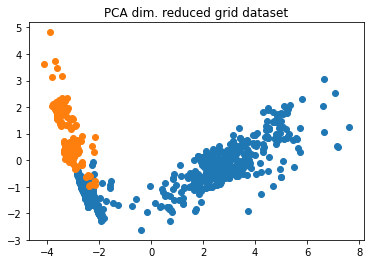

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

n = 4  # dimension of each data point
sample_Total, training_input, test_input, class_labels,sample_train, sample_test, label_train, label_test = ind1(training_size=700,test_size=300, n=n, plot_data=True)
temp = [test_input[k] for k in test_input]
total_array = np.concatenate(temp)

# without optimizer

In [7]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance

sv_qi = QuantumInstance(
    BasicAer.get_backend("statevector_simulator"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

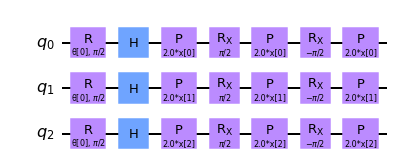

In [8]:
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit import ParameterVector

user_params = ParameterVector("θ",length=3)
fm0 = QuantumCircuit(3)
fm0.ry(user_params[0], 0)
fm0.ry(user_params[0], 1)
fm0.ry(user_params[0], 2)
#fm0.ry(user_params[0], 3)
#fm0.ry(user_params[0], 4)


fm1 = PauliFeatureMap(feature_dimension=3, reps=1, paulis=['Z','Y','Z'])


feature_map = fm0.compose(fm1)
#feature_map = ZZFeatureMap(2)
previous_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=sv_qi)
feature_map.decompose().draw('mpl')

In [9]:
from qiskit_machine_learning.algorithms import QSVC
import time

start = time.time()
qsvc = QSVC(quantum_kernel=previous_kernel)
qsvc.fit(sample_train, label_train)
elapsed = time.time() - start
print("Train Accuracy= ",qsvc.score(sample_train, label_train))

print(f"Training time: {round(elapsed)} milli seconds")

Train Accuracy=  0.9671428571428572
Training time: 4 milli seconds


In [10]:
from sklearn.metrics import precision_score,  recall_score, f1_score, accuracy_score
from sklearn import metrics
labels_test = qsvc.predict(sample_test)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=label_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.9537869062901155


In [11]:
from sklearn.metrics import precision_score,  recall_score, f1_score, accuracy_score
print("Precision = ", metrics.precision_score(label_test, labels_test, average='macro', zero_division=1))
print("Recall Score=", metrics.recall_score(label_test, labels_test, average='macro'))
print("Accuracy=", metrics.balanced_accuracy_score(label_test, labels_test))
print("F1 Score=", metrics.f1_score(label_test, labels_test, average='macro'))

Precision =  0.9537869062901155
Recall Score= 0.9537869062901155
Accuracy= 0.9537869062901155
F1 Score= 0.9537869062901155


Size of traaining 700
Size of test 300


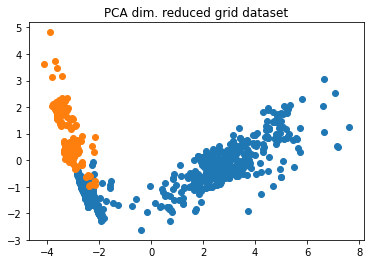

In [12]:
n = 3  # dimension of each data point
sample_Total, training_input, test_input, class_labels,sample_train, sample_test, label_train, label_test = ind1(training_size=700,test_size=300, n=n, plot_data=True)
#temp = [test_input[k] for k in test_input]
#total_array = np.concatenate(temp)


class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

     ┌──────────┐┌──────────────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                                 ├
     ├──────────┤│                                  │
q_1: ┤ Ry(θ[0]) ├┤1 PauliFeatureMap(x[0],x[1],x[2]) ├
     ├──────────┤│                                  │
q_2: ┤ Ry(θ[0]) ├┤2                                 ├
     └──────────┘└──────────────────────────────────┘
Trainable parameters: θ, ['θ[0]']


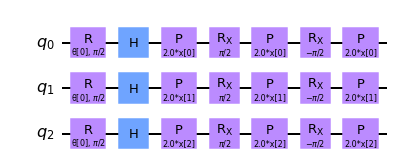

In [13]:
user_params = ParameterVector("θ", 1)
fm0 = QuantumCircuit(3)
fm0.ry(user_params[0], 0)
fm0.ry(user_params[0], 1)
fm0.ry(user_params[0], 2)


# Use ZZFeatureMap to represent input data
#fm1 = ZZFeatureMap(2)
fm1=PauliFeatureMap(feature_dimension=3, reps=1, paulis=['Z','Y','Z'])
# Create the feature map, composed of our two circuits
fm = fm0.compose(fm1)

print(circuit_drawer(fm))
print(f"Trainable parameters: {user_params}")
fm.decompose().draw(output='mpl')

In [14]:
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import COBYLA,ADAM
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit.providers.aer import AerSimulator
backend= BasicAer.get_backend("statevector_simulator")


# Instantiate quantum kernel
quant_kernel1 = QuantumKernel(fm, user_parameters=user_params, quantum_instance=backend)

# Set up the optimizer
cb_qkt = QKTCallback()
cobyla=COBYLA(maxiter=100)
#spsa_opt1 = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)

# Instantiate a quantum kernel trainer.
qkt1 = QuantumKernelTrainer(
    quantum_kernel=quant_kernel1, loss="svc_loss", optimizer=cobyla, initial_point=[np.pi / 2]
)

In [15]:
import time
import matplotlib.pyplot as plt

#objective_func_vals = []
#plt.rcParams["figure.figsize"] = (12, 6)
start = time.time()
# fit classifier to data
#vqc.fit(sample_train, y_one_hot)
qka_results=qkt1.fit(sample_train, label_train)
optimized_kernel1 = qka_results.quantum_kernel
print(qka_results)

elapsed = time.time() - start
# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
#vqc.score(sample_train, y_one_hot)
print(f"Training time: {round(elapsed)} milli seconds")

{   'optimal_circuit': None,
    'optimal_parameters': {ParameterVectorElement(θ[0]): 3.5926689830448963},
    'optimal_point': array([3.59266898]),
    'optimal_value': 94.0687687838781,
    'optimizer_evals': 22,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x00000293454DF9A0>}
Training time: 87 milli seconds


In [16]:
from qiskit_machine_learning.algorithms import QSVC
from sklearn import metrics
# Use QSVC for classification
qsvc1 = QSVC(quantum_kernel=optimized_kernel1)

# Fit the QSVC
qsvc1.fit(sample_train, label_train)
qsvc1.score(sample_train, label_train)


0.96

In [17]:
labels_train = qsvc1.predict(sample_train)
accuracy_train = metrics.balanced_accuracy_score(y_true=label_train, y_pred=labels_train)
print(f"accuracy test: {accuracy_train}")

accuracy test: 0.9374230105937422


In [18]:
from sklearn.metrics import precision_score,  recall_score, f1_score, accuracy_score
from sklearn import metrics
labels_test = qsvc1.predict(sample_test)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=label_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.9387676508344031


In [19]:
from sklearn.metrics import precision_score,  recall_score, f1_score, accuracy_score
print("Precision = ", metrics.precision_score(label_test, labels_test, average='weighted', zero_division=1))
print("Recall Score=", metrics.recall_score(label_test, labels_test, average='weighted'))
print("Accuracy=", metrics.balanced_accuracy_score(label_test, labels_test))
print("F1 Score=", metrics.f1_score(label_test, labels_test, average='weighted'))

Precision =  0.9440072068431332
Recall Score= 0.9433333333333334
Accuracy= 0.9387676508344031
F1 Score= 0.9435649026322602


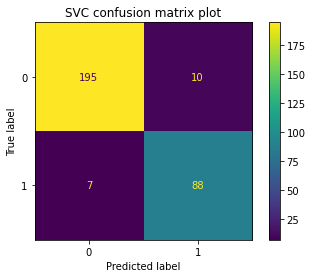

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
svc_cm_plot1 = ConfusionMatrixDisplay.from_estimator(qsvc1, sample_test, label_test);
svc_cm_plot1.ax_.set_title("SVC confusion matrix plot");

In [21]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb.fit(label_test)
y_test_1 = lb.transform(label_test)
y_pred_1 = lb.transform(labels_test)

roc_auc_score(y_test_1, y_pred_1,  multi_class="ovo", average='macro')

0.9387676508344031

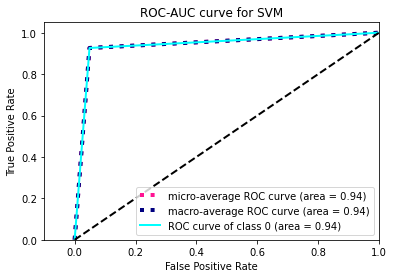

In [22]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
n_classes = 1
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_1[:, i], y_pred_1[:, i]) # Need to change
    #print(fpr[i], tpr[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_1.ravel(), y_pred_1.ravel())# Need to change
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve for SVM')
plt.legend(loc="lower right")
plt.show()